In [1]:
import numpy as np
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
from art.utils import to_categorical
from art.estimators.classification import KerasClassifier
from tensorflow.keras.models import load_model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# Load the dataset to allow for adversarial attacks
# CHANGE USERNAME WHEN WORKING BETWEEN LAPTOP AND DESKTOP!!

import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_dataset(base_dir, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = {'hearts': 0, 'diamonds': 1, 'clubs': 2, 'spades': 3}
    
    # Navigate through each suit folder
    for suit in class_labels.keys():
        suit_dir = os.path.join(base_dir, suit)
        print(f"Checking suit directory: {suit_dir}")  # Debug print
        if os.path.isdir(suit_dir):
            label_index = class_labels[suit]
            print(f"Label index for {suit}: {label_index}")  # Debug print

            # Navigate through each card folder within the suit folder
            for card_folder in os.listdir(suit_dir):
                card_folder_path = os.path.join(suit_dir, card_folder)
                #print(f"Checking card folder: {card_folder_path}")  # Add this debug print
                if os.path.isdir(card_folder_path):
                    # Load each image from the card folder
                    for image_file in os.listdir(card_folder_path):
                        image_path = os.path.join(card_folder_path, image_file)
                        image = load_img(image_path, target_size=target_size)
                        #print(f"Loading image: {image_path}")  # Debug print
                        image_array = img_to_array(image)
                        images.append(image_array)
                        labels.append(label_index)
    
    # After loading all images and labels, shuffle them
    combined = list(zip(images, labels))
    np.random.shuffle(combined)

    images[:], labels[:] = zip(*combined)                    
    
    images = np.array(images, dtype='float32') / 255.0  # Normalize to [0, 1]
    labels = np.array(labels, dtype='int32')
    
    # Print some of the labels to verify they are correct
    print(labels[:100])
    
    return images, labels, class_labels

# Directory Definitions
base_dir = "c:\\Users\\alec\\OneDrive - University of North Georgia\\FALL 2023\\Cyber capstone\\Experimentation\\SortedData"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Usage
train_images, train_labels, train_class_labels = load_dataset(train_dir)
valid_images, valid_labels, valid_class_labels = load_dataset(validation_dir)
test_images, test_labels, test_class_labels = load_dataset(test_dir)

# Check shapes and class labels
print(train_images.shape, train_labels.shape)
print(valid_images.shape, valid_labels.shape)
print(test_images.shape, test_labels.shape)
print(train_class_labels)

Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\hearts
Label index for hearts: 0
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\diamonds
Label index for diamonds: 1
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\clubs
Label index for clubs: 2
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\spades
Label index for spades: 3
[1 3 3 2 2 2 0 1 0 2 0 0 1 1 3 0 1 2 3 3 3 3 2 1 1 3 1 1 1 1 2 2 2 0 3 1 3
 0 0 0 1 0 2 1 3 2 2 1 0 0 0 2 0 0 0 1 0 0 0 1 3 2 1 2 1 0 1 2 1 3 3 1 1 2
 3 3 2 2 2 1 2 1 3 3 3 2 1 2 3 0 2 1 3 0 3 2 3 2 1 3]
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation

In [3]:
# Load pretrained model
model = load_model('PlayingCardAdversarialTrain.h5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 64)       

In [4]:
# Fast Gradient Method attack

classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack.generate(x=test_images)
score_adv = model.evaluate(
    x=x_test_adv,
    y=test_labels
    )
print(f"Adversarial test set accuracy: {score_adv[1]:.2f} ")

C:\Users\alec\miniconda3\envs\jupyterenv\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\alec\miniconda3\envs\jupyterenv\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adversarial test set accuracy: 0.19 


Accuracy on original test set:  0.96
Accuracy on adversarial test set:  0.19
(260,) (260, 4)


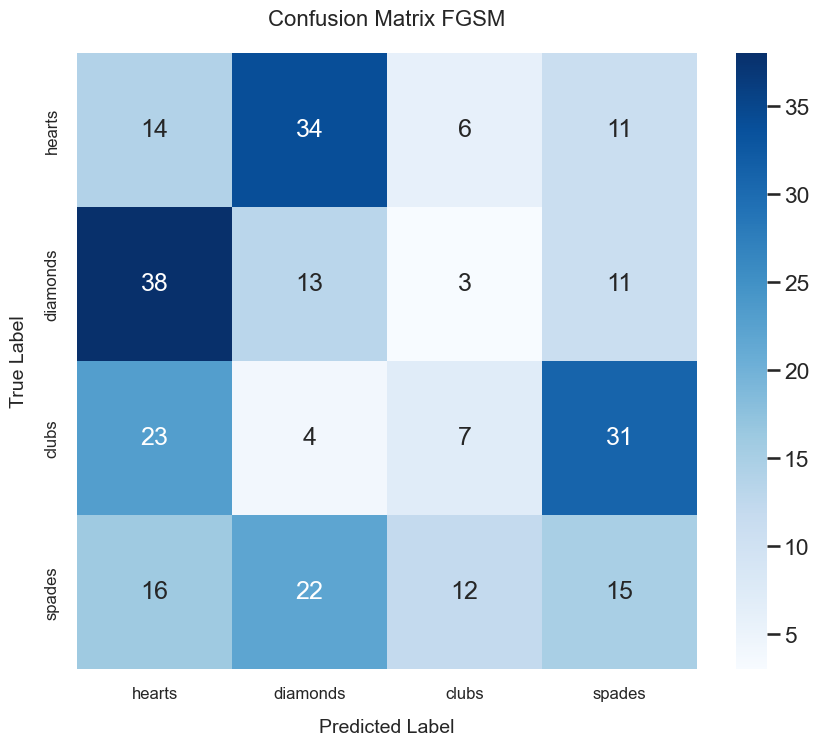

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.15      0.22      0.18        65
           1       0.18      0.20      0.19        65
           2       0.25      0.11      0.15        65
           3       0.22      0.23      0.23        65

    accuracy                           0.19       260
   macro avg       0.20      0.19      0.19       260
weighted avg       0.20      0.19      0.19       260



In [5]:
# Fast Gradient method attack impact

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

score_org = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Predictions on original and adversarial test sets
original_predictions = model.predict(test_images)
adversarial_predictions = model.predict(x_test_adv)

true_labels=test_labels

# Print accuracy
print(f"Accuracy on original test set:  {score_org[1]:.2f}")
print(f"Accuracy on adversarial test set:  {score_adv[1]:.2f}")

print(true_labels.shape, adversarial_predictions.shape)

# Convert the probabilities in adversarial_predictions to class labels
adversarial_predictions = np.argmax(adversarial_predictions, axis=1)

# Calculate and display confusion matrix
cm=confusion_matrix(true_labels, adversarial_predictions)

# Set the style and context for the plot
sns.set_style('whitegrid')  # You can choose 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set_context('talk')     # Other options include 'paper', 'notebook', 'talk', and 'poster'

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)

# Enhance the appearance of the heatmap
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=12)

plt.xlabel('Predicted Label', labelpad=12, fontsize=14)
plt.ylabel('True Label', labelpad=12, fontsize=14)
plt.title('Confusion Matrix FGSM', pad=20, fontsize=16)

plt.show()

#classification report
print("Classificaiton Report:")
print(classification_report(true_labels, adversarial_predictions))

In [6]:
from tensorflow.keras import backend as K

# Clearing the TensorFlow backend
K.clear_session()


In [7]:
#================================================================================================================#
#PGD Attack

In [8]:
# Load pretrained model
model = load_model('PlayingCardAdversarialTrain.h5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 64)       

In [9]:
# FGSM attack

classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)
attack = ProjectedGradientDescent(estimator=classifier, eps=0.1, max_iter=10, eps_step=0.01)
x_test_adv_pgd = attack.generate(x=test_images)
score_adv_pgd = model.evaluate(x=x_test_adv_pgd, y=test_labels)

C:\Users\alec\miniconda3\envs\jupyterenv\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\alec\miniconda3\envs\jupyterenv\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on original test set:  0.96
Accuracy on adversarial test set:  0.03
(260,) (260, 4)


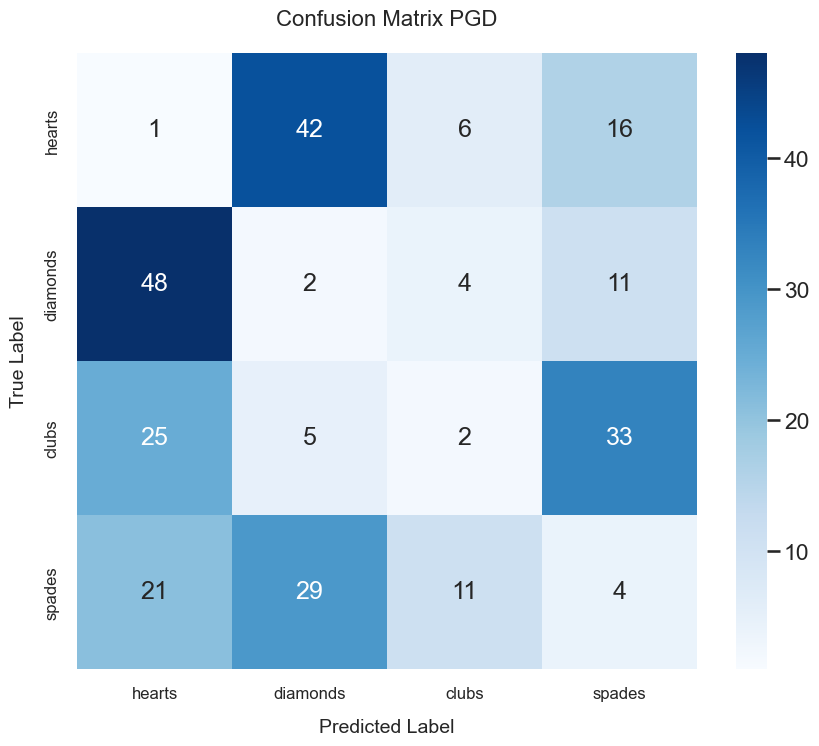

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.01      0.02      0.01        65
           1       0.03      0.03      0.03        65
           2       0.09      0.03      0.05        65
           3       0.06      0.06      0.06        65

    accuracy                           0.03       260
   macro avg       0.05      0.03      0.04       260
weighted avg       0.05      0.03      0.04       260



In [10]:
# PGD method attack impact

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

score_org = model.evaluate(
    x=test_images,
    y=test_labels
    )

score_adv = model.evaluate(
    x=x_test_adv_pgd,
    y=test_labels
    )

# Predictions on original and adversarial test sets
original_predictions = model.predict(test_images)
adversarial_predictions = model.predict(x_test_adv_pgd)

true_labels=test_labels

# Print accuracy
print(f"Accuracy on original test set:  {score_org[1]:.2f}")
print(f"Accuracy on adversarial test set:  {score_adv[1]:.2f}")

print(true_labels.shape, adversarial_predictions.shape)

# Convert the probabilities in adversarial_predictions to class labels
adversarial_predictions = np.argmax(adversarial_predictions, axis=1)

# Calculate and display confusion matrix
cm=confusion_matrix(true_labels, adversarial_predictions)

# Set the style and context for the plot
sns.set_style('whitegrid')  # You can choose 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set_context('talk')     # Other options include 'paper', 'notebook', 'talk', and 'poster'

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)

# Enhance the appearance of the heatmap
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=12)

plt.xlabel('Predicted Label', labelpad=12, fontsize=14)
plt.ylabel('True Label', labelpad=12, fontsize=14)
plt.title('Confusion Matrix PGD', pad=20, fontsize=16)

plt.show()

#classification report
print("Classificaiton Report:")
print(classification_report(true_labels, adversarial_predictions))

In [11]:
from tensorflow.keras import backend as K

# Clearing the TensorFlow backend
K.clear_session()


In [12]:
#========================================================================================
# Carlini L2 Method attack

In [13]:
model = load_model("PlayingCardAdversarialTrain.h5")

In [15]:

# Assuming 'model' is your pre-trained Keras model
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Carlini & Wagner L2 attack initialization
attack = CarliniL2Method(classifier=classifier, 
                         confidence=0.0,            # Confidence of adversarial examples: a higher value produces examples that are farther away from the decision boundary of the model, but more likely to be classified as a specific target class.
                         targeted=False,            # Non-targeted attack
                         learning_rate=0.1,        # The learning rate for the attack algorithm. Smaller values produce better results but take longer to converge.
                         max_iter=2,               # The maximum number of iterations. More iterations produce better results but take longer to run.
                         binary_search_steps=10,    # The number of search steps to perform binary search over the const c.
                         batch_size=1)              # The size of the batch on which adversarial samples are generated.

# Generate adversarial examples
x_test_adv = attack.generate(x=test_images)




C&W L_2:   0%|          | 0/260 [00:00<?, ?it/s]

C:\Users\alec\miniconda3\envs\jupyterenv\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on original test set:  0.96
Accuracy on adversarial test set:  0.81
(260,) (260, 4)


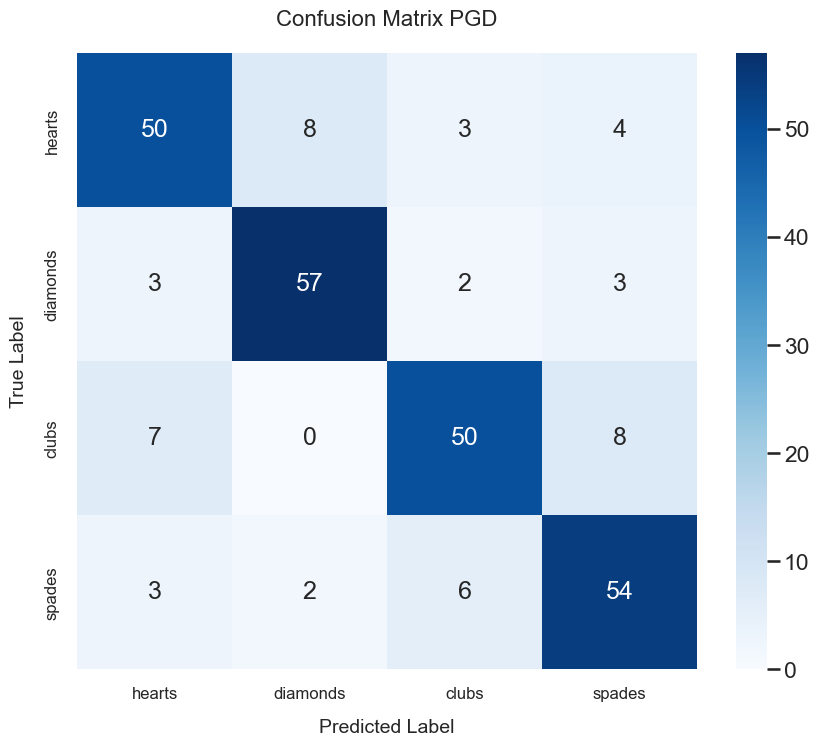

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        65
           1       0.85      0.88      0.86        65
           2       0.82      0.77      0.79        65
           3       0.78      0.83      0.81        65

    accuracy                           0.81       260
   macro avg       0.81      0.81      0.81       260
weighted avg       0.81      0.81      0.81       260



In [16]:
# C&W attack impact

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

score_org = model.evaluate(
    x=test_images,
    y=test_labels
    )

score_adv = model.evaluate(
    x=x_test_adv,
    y=test_labels
    )

# Predictions on original and adversarial test sets
original_predictions = model.predict(test_images)
adversarial_predictions = model.predict(x_test_adv)

true_labels=test_labels

# Print accuracy
print(f"Accuracy on original test set:  {score_org[1]:.2f}")
print(f"Accuracy on adversarial test set:  {score_adv[1]:.2f}")

print(true_labels.shape, adversarial_predictions.shape)

# Convert the probabilities in adversarial_predictions to class labels
adversarial_predictions = np.argmax(adversarial_predictions, axis=1)

# Calculate and display confusion matrix
cm=confusion_matrix(true_labels, adversarial_predictions)

# Set the style and context for the plot
sns.set_style('whitegrid')  # You can choose 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set_context('talk')     # Other options include 'paper', 'notebook', 'talk', and 'poster'

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)

# Enhance the appearance of the heatmap
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=12)

plt.xlabel('Predicted Label', labelpad=12, fontsize=14)
plt.ylabel('True Label', labelpad=12, fontsize=14)
plt.title('Confusion Matrix PGD', pad=20, fontsize=16)

plt.show()

#classification report
print("Classificaiton Report:")
print(classification_report(true_labels, adversarial_predictions))